# Intro to FAST data

> Abstract: Some datasets are available more rapidly than others (for space weather monitoring). These are delivered through a special "FAST" processing chain, as opposed to the normal operational "OPER" chain. They are available under different collection names containing the string "FAST". Here we compare the availability and quality of FAST data in contrast to OPER data.

NB: Data is currently only available on the DISC machine for select users

In [1]:
SERVER_URL = 'https://vires.services/ows'

In [2]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib,tqdm

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.6
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2
tqdm       : 4.66.1



In [3]:
from viresclient import SwarmRequest
import datetime as dt
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from operator import or_
from functools import reduce

## Which data are available FAST?

In [4]:
request = SwarmRequest(SERVER_URL)

all_collections = request.available_collections(details=False)
# Identify collections with FAST in the name
collections = {group: [c for c in colls if "FAST" in c] for (group, colls) in all_collections.items()}
# Filter the empty groups
collections = {group: colls for group, colls in collections.items() if len(colls) > 0}
collections


{'MAG': ['SW_FAST_MAGA_LR_1B', 'SW_FAST_MAGB_LR_1B', 'SW_FAST_MAGC_LR_1B'],
 'MAG_HR': ['SW_FAST_MAGA_HR_1B', 'SW_FAST_MAGB_HR_1B', 'SW_FAST_MAGC_HR_1B'],
 'EFI': ['SW_FAST_EFIA_LP_1B', 'SW_FAST_EFIB_LP_1B', 'SW_FAST_EFIC_LP_1B'],
 'MOD_SC': ['SW_FAST_MODA_SC_1B', 'SW_FAST_MODB_SC_1B', 'SW_FAST_MODC_SC_1B']}

Let's use `'SW_FAST_MAGA_LR_1B'` as an example and compare to `'SW_OPER_MAGA_LR_1B'`.

We can query the availability times of the underlying products:

In [5]:
fast_availability = request.available_times("SW_FAST_MAGA_LR_1B")
fast_availability

starttime                          endtime  \
0   2023-11-01 23:19:21+00:00        2023-11-02 21:43:21+00:00   
1   2023-11-02 21:43:21+00:00 2023-11-03 09:58:20.001000+00:00   
2   2023-11-03 09:58:21+00:00 2023-11-03 22:24:20.001000+00:00   
3   2023-11-03 22:24:21+00:00 2023-11-04 08:00:19.001000+00:00   
4   2023-11-04 08:00:21+00:00 2023-11-04 23:32:20.001000+00:00   
..                        ...                              ...   
165 2024-01-22 06:00:21+00:00 2024-01-22 16:40:19.001000+00:00   
166 2024-01-22 16:40:21+00:00 2024-01-23 06:54:20.001000+00:00   
167 2024-01-23 06:54:21+00:00 2024-01-23 16:13:19.001000+00:00   
168 2024-01-23 16:13:21+00:00 2024-01-24 06:27:20.001000+00:00   
169 2024-01-24 06:27:21+00:00 2024-01-24 15:43:19.001000+00:00   

                  bbox                                         identifier  
0    (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20231101T231921_20231102T21...  
1    (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20231102T214321_20231103T09...  
2    (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20231103T095821_20231103T22...  
3    (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20231103T222421_20231104T08...  
4    (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20231104T080021_20231104T23...  
..                 ...                                                ...  
165  (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20240122T060021_20240122T16...  
166  (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20240122T164021_20240123T06...  
167  (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20240123T065421_20240123T16...  
168  (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20240123T161321_20240124T06...  
169  (-90,-180,90,180)  SW_FAST_MAGA_LR_1B_20240124T062721_20240124T15...  

[170 rows x 4 columns]

**Note: VirES only keeps a rolling store of the most recent month of FAST data.**

In [6]:
oper_availability = request.available_times("SW_OPER_MAGA_LR_1B")
oper_availability

starttime                          endtime  \
0    2013-11-25 11:02:52+00:00 2013-11-25 23:59:59.001000+00:00   
1    2013-11-26 00:00:00+00:00 2013-11-26 23:59:59.001000+00:00   
2    2013-11-27 00:00:00+00:00 2013-11-27 23:59:59.001000+00:00   
3    2013-11-28 00:00:00+00:00 2013-11-28 23:59:59.001000+00:00   
4    2013-11-29 00:00:00+00:00 2013-11-29 23:59:59.001000+00:00   
...                        ...                              ...   
3688 2024-01-16 00:00:00+00:00 2024-01-16 23:59:59.001000+00:00   
3689 2024-01-17 00:00:00+00:00 2024-01-17 23:59:59.001000+00:00   
3690 2024-01-18 00:00:00+00:00 2024-01-18 23:59:59.001000+00:00   
3691 2024-01-19 00:00:00+00:00 2024-01-19 23:59:59.001000+00:00   
3692 2024-01-20 00:00:00+00:00 2024-01-20 23:59:59.001000+00:00   

                   bbox                                         identifier  
0     (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20131125T110252_20131125T23...  
1     (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20131126T000000_20131126T23...  
2     (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20131127T000000_20131127T23...  
3     (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20131128T000000_20131128T23...  
4     (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20131129T000000_20131129T23...  
...                 ...                                                ...  
3688  (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20240116T000000_20240116T23...  
3689  (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20240117T000000_20240117T23...  
3690  (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20240118T000000_20240118T23...  
3691  (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20240119T000000_20240119T23...  
3692  (-90,-180,90,180)  SW_OPER_MAGA_LR_1B_20240120T000000_20240120T23...  

[3693 rows x 4 columns]

In [7]:
print(f"Latest OPER: {oper_availability['endtime'].iloc[-1]}")
print(f"Latest FAST: {fast_availability['endtime'].iloc[-1]}")

Latest OPER: 2024-01-20 23:59:59.001000+00:00
Latest FAST: 2024-01-24 15:43:19.001000+00:00


As you can see above, `OPER` data is delivered in full-day chunks with a few days delay. `FAST` data are typically delivered in several-hour chunks and available as soon as possible, subject to downlink opportunities from the satellite passes over the ground stations and subsequent processing time.

## Accessing FAST data

`FAST` data are identical in format to `OPER` data so can be accessed and used in the same way through VirES.

In the following example, we access the latest available day of `OPER` data and compare to the available `FAST` data, for each of Swarm A, B, C.

In [8]:
collection_root = "SW_{}_MAG{}_LR_1B"

def find_latest_oper(spacecraft="A"):
    """Identify the latest availability time for OPER data"""
    collection = collection_root.format("OPER", spacecraft)
    request = SwarmRequest(SERVER_URL)
    times = request.available_times(collection)
    return times['endtime'].iloc[-1].to_pydatetime()

def fetch_data(spacecraft="A", type="OPER", start=None, end=None):
    """Fetch either OPER or FAST data"""
    collection = collection_root.format(type, spacecraft)
    request = SwarmRequest(SERVER_URL)
    request.set_collection(collection)
    request.set_products(
        measurements=["B_NEC", "Flags_B"],
        models=["CHAOS"],
    )
    data = request.get_between(start, end, asynchronous=False, show_progress=False)
    ds = data.as_xarray()
    ds["B_NEC_res_CHAOS"] = ds["B_NEC"] - ds["B_NEC_CHAOS"]
    return ds

In [9]:
# Find the latest availability times of OPER data per-satellite
oper_end_times = {sc: find_latest_oper(sc) for sc in "ABC"}
oper_end_times

{'A': datetime.datetime(2024, 1, 20, 23, 59, 59, 1000, tzinfo=datetime.timezone.utc),
 'B': datetime.datetime(2024, 1, 20, 23, 59, 59, 1000, tzinfo=datetime.timezone.utc),
 'C': datetime.datetime(2024, 1, 20, 23, 59, 59, 1000, tzinfo=datetime.timezone.utc)}

In [10]:
data_fast = {}
data_oper = {}
for sc in tqdm("ABC"):
    # Fetch the latest available day of OPER data
    oper_end = oper_end_times[sc] + dt.timedelta(seconds=1)
    oper_start = oper_end - dt.timedelta(days=1)
    data_oper[sc] = fetch_data(sc, "OPER", oper_start, oper_end)
    # Fetch all FAST data from then until now
    data_fast[sc] = fetch_data(sc, "FAST", oper_end, dt.datetime.now())

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:06<00:13,  6.60s/it]

 67%|██████▋   | 2/3 [00:12<00:06,  6.30s/it]

100%|██████████| 3/3 [00:18<00:00,  6.24s/it]

100%|██████████| 3/3 [00:18<00:00,  6.29s/it]

In [11]:
def flag_filter(ds):
    """A simplistic filter for close-to-nominal data"""
    # Filtering by Flags_B
    # For flag meanings, see https://swarmhandbook.earth.esa.int/catalogue/SW_MAGx_LR_1B
    # This includes Charlie data, where the ASM was lost
    nominal = 0b0000
    asm_off = 0b0001
    vfm_asm_discrepency = 0b1000
    bitmask_filters = (nominal, asm_off, vfm_asm_discrepency)
    flags = ds["Flags_B"]
    flags_masked = reduce(or_, [flags & x for x in bitmask_filters])
    return ds.where(flags == flags_masked)

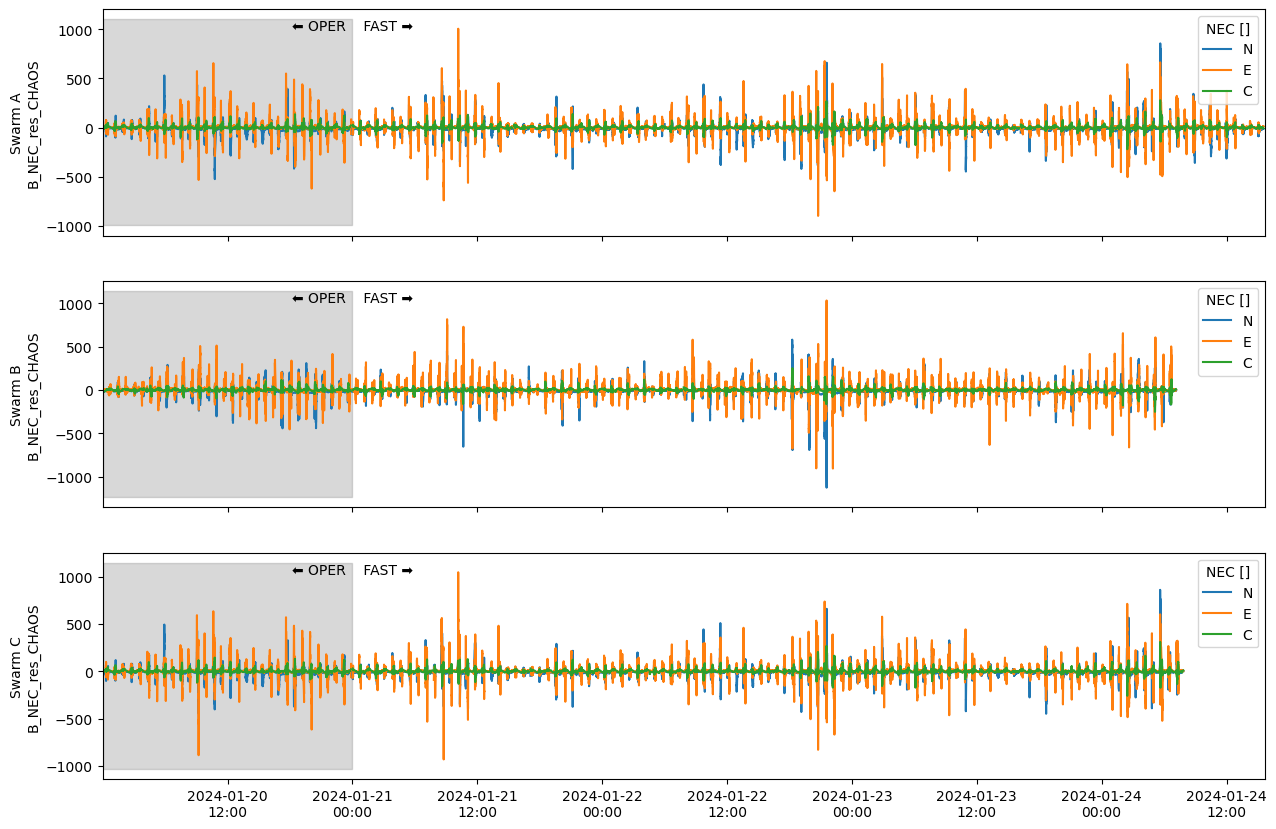

In [12]:
# Identify the minimal and maximal times in the datasets
tmin = min(data_oper[sc]["Timestamp"].data[0] for sc in "ABC")
tmax = max(data_fast[sc]["Timestamp"].data[-1] for sc in "ABC")

fig, axes = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
for ax, sc in zip(axes, "ABC"):
    # Remove bad data before plotting
    ds_oper_nominal = flag_filter(data_oper[sc])
    ds_fast_nominal = flag_filter(data_fast[sc])
    ax.set_prop_cycle("color", ["tab:blue", "tab:orange", "tab:green"])
    ds_oper_nominal["B_NEC_res_CHAOS"].plot.line(x="Timestamp", ax=ax)
    ds_fast_nominal["B_NEC_res_CHAOS"].plot.line(x="Timestamp", ax=ax)
    ax.set_xlim(tmin, tmax)
    # Add shading behind OPER data section
    oper_start = data_oper[sc]["Timestamp"].data[0]
    oper_end = data_oper[sc]["Timestamp"].data[-1]
    ymin, ymax = ax.get_ylim()
    ax.fill_betweenx((ymin, ymax), oper_start, oper_end, alpha=0.3, color="grey")
    # Add and fix some labelling
    ax.text(oper_end, ymax, "⬅️ OPER    FAST ➡️", ha="center", va="top")
    ax.set_xlim(oper_start, ax.get_xlim()[-1])
    ax.set_xlabel("")
    ax.set_ylabel(f"Swarm {sc}\n{ax.get_ylabel()}")

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y-%m-%d\n%H:%M"))